In [12]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

In [13]:
# Basic PVT Properties
pb = 1050
api=20.7
sg_gas=.85
# Parameters
temp=205

In [14]:
def api_to_sg(api):
    api = np.atleast_1d(api)
    sg = 141.5 / (131.5 + api)
    return sg
def sg_to_api(sg):
    sg = np.atleast_1d(sg)
    api = (141.5 / sg) - 131.5
    return api

In [15]:
def correlated_property(x,a,b):
    return a*x+b

In [16]:
def rs_correlations(p=None, pb=pb, temp=temp, api=api, sg_gas=sg_gas,method='standing',is_psig=True):
    if is_psig:
        p=p+14.65

    """
    Estimate the Gas-Oil Ratio using Standing Correlation
    Input:
        p -> (int,float,np.array) Interest Pressure [psi]
        pb -> (int,float,np.array) Bubble Point [psi]
        temp -> (int,float,np.array)Temperature [F]
        api -> (int,float,np.array)Oil API gravity [API]
        sg_gas -> (int,float,np.array) Gas specifi gravity
        rsb -> (int,float,np.array) Gas oil ration at bubble point
        method -> (list, default 'standing')List of correlation methods
                  ['standing',laster,'vazquez_beggs','glaso','valarde']
                  * Valarde method builds rs below pb given rsb

    Return:
        rs -> (pd.DataFrame) Gas Oil Ratio indexed by pressure
    Source: Correlaciones Numericas PVT - Carlos Banzer
    """
    p=np.array(p)
    assert isinstance(p, (int, float, list, np.ndarray))
    p = np.atleast_1d(p)

    assert isinstance(pb, (int, float, list, np.ndarray))
    pb = np.atleast_1d(pb)

    assert isinstance(temp, (int, float, list, np.ndarray))
    temp = np.atleast_1d(temp)

    assert isinstance(api, (int, float, list, np.ndarray))
    api = np.atleast_1d(api)

    assert isinstance(sg_gas, (int, float, list, np.ndarray))
    sg_gas = np.atleast_1d(sg_gas)
    assert isinstance(method, (str, list))

    methods = []

    if isinstance(method, str):
        methods.append(method)
        multiple = False
    else:
        methods.extend(method)
        multiple = True
    rs_dict = {}
    p_sat = np.zeros(p.shape)
    p_sat[p >= pb] = pb
    p_sat[p < pb] = p[p < pb]

    if 'standing' in methods:
        rs = sg_gas * np.power(((p_sat / 18.2) + 1.4) * np.power(10, 0.0125 * api - 0.00091 * temp), 1.2048)
        rs_dict['rs_standing'] = rs

    if 'laster' in methods:
        array_shape = p_sat * sg_gas * temp * p
        mo = np.zeros(api.shape)
        mo[api <= 40] = 630 - 10 * api[api <= 40]
        mo[api > 40] = 73110 * np.power(api[api > 40], -1.562)

        pb_factor = (p_sat * sg_gas) / (temp + 459.67)

        # estimate yg

        yg = np.zeros(array_shape.shape)

        yg[pb_factor < 3.29] = 0.359 * np.log(1.473 * pb_factor[pb_factor < 3.29] + 0.476)
        yg[pb_factor >= 3.29] = np.power(0.121 * pb_factor[pb_factor >= 3.29] - 0.236, 0.281)

        sg_oil = api_to_sg(api)
        rs = (132755 * sg_oil * yg) / (mo * (1 - yg))
        rs_dict['rs_laster'] = rs

    if 'vazquez_beggs' in methods:
        # Constants c1, c2, c3
        c1 = np.zeros(api.shape)
        c2 = np.zeros(api.shape)
        c3 = np.zeros(api.shape)

        c1[api <= 30] = 0.0362
        c1[api > 30] = 0.0178

        c2[api <= 30] = 1.0937
        c2[api > 30] = 1.1870

        c3[api <= 30] = 25.724
        c3[api > 30] = 23.931

        rs = c1 * sg_gas * np.power(p_sat, c2) * np.exp((c3 * api) / (temp + 460))
        rs_dict['rs_vazquez_beggs'] = rs

    if 'glaso' in methods:
        f = np.power(10, 2.8869 - np.power(14.1811 - 3.3093 * np.log10(p_sat), 0.5))
        rs = sg_gas * np.power(f * (np.power(api, 0.989) / np.power(temp, 0.172)), 1.2255)
        rs_dict['rs_glaso'] = rs

    if is_psig:
        p=p-14.65
    rs_df = pd.DataFrame(rs_dict, index=p) if multiple == True else pd.DataFrame({'rs': rs}, index=p)
    rs_df.index.name = 'pressure'
    return rs_df

In [17]:
def correlated_rs(inputs=None, pb=pb, temp=temp, api=api, sg_gas=sg_gas,method=["standing","glaso","vazquez_beggs"],pressure_range=np.arange(start=0,stop=pb,step=int(pb/100))):
    p=inputs["p"]
    actual_rs=inputs["rs"]
    rs=rs_correlations(p=p,pb=pb,temp=temp,api=api,sg_gas=sg_gas,method=method)
    a_values=[]
    b_values=[]
    methods=[]
    result=pd.DataFrame()
    before_matching=pd.DataFrame()
    for column in rs.columns:
        fitting_parameters=curve_fit(correlated_property, rs[column], actual_rs)
        a=fitting_parameters[0][0]
        b=fitting_parameters[0][1]
        print(str(column)[3:])
        result[column]=a*rs_correlations(p=pressure_range,pb=pb,temp=temp,api=api,sg_gas=sg_gas,method=str(column)[3:])+b
        before_matching[column]=rs_correlations(p=pressure_range,pb=pb,temp=temp,api=api,sg_gas=sg_gas,method=str(column)[3:])
        a_values.append(a)
        b_values.append(b)
    parameters = pd.DataFrame(columns=("Parameter1","Parameter2"))
    parameters["Parameter1"]=a_values
    parameters["Parameter2"]=b_values
    return result,inputs,before_matching,parameters

In [18]:
df = pd.read_excel('PVT DATA.xlsx',sheet_name=1)
df.head()

,Temperature F,Pressure PSIG,Bubble point Psig,GOR scf/stb,Bo bbl/stb,Viscosity CP,Bg bbl/scf,Mg CP,Unnamed: 8,Unnamed: 9
0,205,4350,1050,180.85,1.15356,5.1477,NaN,NaN,Oil API,20.70
1,205,4060,1050,180.85,1.15544,5.0585,NaN,NaN,Gas Specific Gravity,0.85
2,205,3770,1050,180.85,1.15751,4.9694,NaN,NaN,NaN,NaN
3,205,3690,1050,180.85,1.15815,4.9448,NaN,NaN,NaN,NaN
4,205,3480,1050,180.85,1.15681,4.8802,NaN,NaN,NaN,NaN


In [19]:
inputs=pd.DataFrame()
inputs["p"]=df["Pressure PSIG"]
inputs["rs"]=df["GOR scf/stb"]
result=correlated_rs(inputs=inputs,pressure_range=np.arange(start=0,stop=4000,step=100))
print(result[3])

standing
vazquez_beggs
glaso
   Parameter1  Parameter2
0    1.093478   27.487787
1    1.136765   25.098864
2    1.441721   13.077091


(5.0, 191.32175759172628)

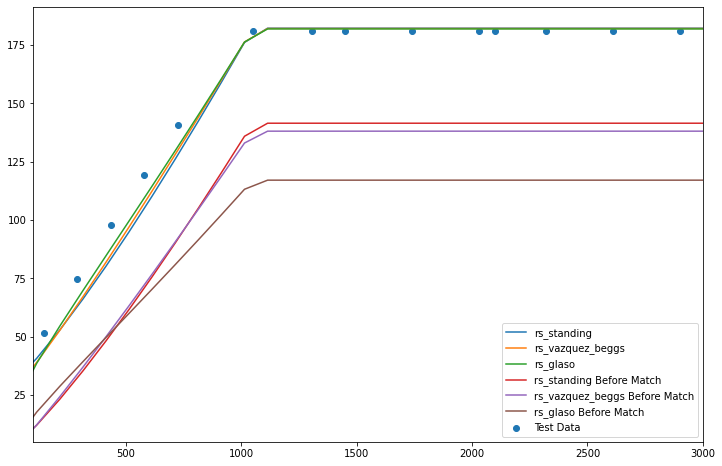

In [20]:
import matplotlib.pyplot as plt
plt.ion()
figure, ax = plt.subplots(figsize=(12, 8))
ax.plot(result[0],label=result[0].columns)
ax.plot(result[2],label=result[2].columns+" Before Match")
ax.scatter(x=result[1]["p"],y=result[1]["rs"],label="Test Data")
ax.legend()
plt.xlim(100,3000)
plt.ylim(5)


In [10]:
def bo(p=None, rs=None, pb=None, temp=None, api=None, sg_gas=None, method='standing'):
    methods = []
    if isinstance(method, str):
        methods.append(method)
        multiple = False
    else:
        methods.extend(method)
        multiple = True

    bo_dict = {}

    if 'standing' in methods:
        sg_oil = api_to_sg(api)
        f = rs * np.sqrt(sg_gas / sg_oil) + 1.25 * temp
        bo = 0.9759 + 12e-5 * np.power(f, 1.2)
        bo_dict['bo_standing'] = bo

    if 'vazquez_beggs' in methods:
        # Constants c1, c2, c3
        c1 = np.zeros(api.shape)
        c2 = np.zeros(api.shape)
        c3 = np.zeros(api.shape)

        c1[api <= 30] = 4.677e-4
        c1[api > 30] = 4.670e-4

        c2[api <= 30] = 1.751e-5
        c2[api > 30] = 1.1e-5

        c3[api <= 30] = -1.8106e-8
        c3[api > 30] = 1.3370e-9

        bo = 1 + c1 * rs + c2 * (temp - 60) * (api / sg_gas) + c3 * rs * (temp - 60) * (api / sg_gas)
        bo_dict['bo_vazquez_beggs'] = bo

    if 'glaso' in methods:
        sg_oil = api_to_sg(api)
        f = rs * np.power(sg_gas / sg_oil, 0.526) + 0.968 * temp
        bo = 1 + np.power(10, -6.58511 + 2.91329 * np.log10(f) - 0.27683 * np.power(np.log10(f), 2))
        bo_dict['bo_glaso'] = bo

    bo_df = pd.DataFrame(bo_dict, index=p) if multiple == True else pd.DataFrame({'bo': bo}, index=p)
    bo_df.index.name = 'pressure'
    return bo_df
